accuracy metrics:
1. confusion matrix
    precision score
    recall score
    f1 score
2. precison-recall curve
    auc score

*requires Graphviz installed to visualize the tree

In [28]:
import pandas as pd
import sklearn as sk
from sklearn.metrics import (
    confusion_matrix, 
    precision_recall_curve,
    auc,
    f1_score,
    recall_score,
    precision_score
)
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter

In [30]:
from sklearn.tree import export_graphviz

In [31]:
def print_confusion_matrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    data = {'Pred 0':[cm[0][0],cm[1][0]],
            'Pred 1':[cm[0][1],cm[1][1]],
            'class.error':[1.0*cm[0][1]/(cm[0][0]+cm[0][1]),1.0*cm[1][0]/(cm[1][0]+cm[1][1])]}
    df = pd.DataFrame(data,index=['Label 0','Label 1'])
    print(df)

In [32]:
# load train and test data
folder = 'dataset'

train_df = pd.read_csv(folder+'/training.csv')
test_df = pd.read_csv(folder+'/testing.csv')

In [33]:
test_df.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.531551  1.321438 -0.741287 -1.165106  1.909055  3.288151 -0.329249   
1 -0.368523 -0.249912  1.677966 -1.942059 -1.929260 -0.348055 -0.276443   
2 -1.062488  0.649612  1.736630 -1.873596 -0.960234 -0.860738 -0.215749   
3 -1.699298 -0.031715 -0.487571 -0.648471  1.103855 -0.207486  1.020651   
4  1.255945  0.357641  0.307025  0.693178 -0.367389 -1.072064  0.090583   

         V9       V10       V11       V12       V14       V16       V17  \
0 -1.023441 -0.691871 -0.518091 -0.065357  0.947140  0.561164 -0.462905   
1 -1.915552  1.257205 -0.653250 -1.221059 -0.799280 -0.226939  0.343076   
2 -1.657257 -0.006823  1.213504 -0.375563  0.345118  1.672125  0.037446   
3 -0.189586 -1.538537  0.654879  0.773011 -1.390766  0.402557  0.583971   
4  0.024534 -0.284297 -0.057014  0.262883 -0.297866  0.476044 -0.008188   

        V18       V19       V24       V27  Amount  Class  
0  0.365443  0.381816  1.039149 -0.122652   33.67      0  
1  0.519629 -0.326690  0.399953 -0.260098   99.00      0  
2 -0.932546  0.299057  0.485493  0.138145    2.39      0  
3  0.804999  0.483000  0.212884 -0.173282  169.33      0  
4 -0.305633 -0.198893  0.346813 -0.022767    1.98      0

In [34]:
# separate independent and dependent variables
train_x = train_df.iloc[:,:-1]
train_y = train_df.iloc[:,-1]
test_x = test_df.iloc[:,:-1]
test_y = test_df.iloc[:,-1]

In [35]:
# build random forest model
RF1 = RandomForestClassifier(n_estimators=100,
                           max_depth=10,
                           min_samples_split=5,
                           random_state=0)

In [36]:
RF1.fit(train_x,train_y)

RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=0)

In [38]:
## testing accuracy
# predicted class
test_y_pred = RF1.predict(test_x)
# predicted probabilty
test_y_pred_proba = RF1.predict_proba(test_x)[:,1]

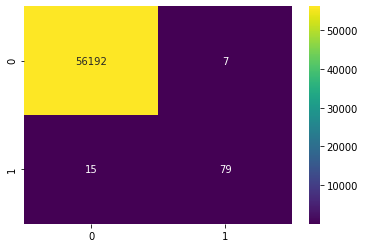

In [39]:
# confusion matrix
sns.heatmap(confusion_matrix(test_y,test_y_pred),annot=True,fmt='d',cmap='viridis')
plt.show()

In [40]:
## Precison-Recall Curve
RF1_precision,RF1_recall,thresholds = precision_recall_curve(test_y,test_y_pred_proba)

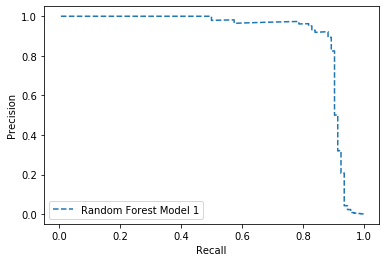

In [41]:
# plot
plt.plot(RF1_recall,RF1_precision,linestyle='--',label='Random Forest Model 1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [42]:
# precision score
precision = precision_score(test_y,test_y_pred)
# recall score
recall = recall_score(test_y,test_y_pred)
print('Random Forest:\nPrecision Score=%.3f\nRecall Score=%.3f' % (precision,recall))
# calculate f1 score and auc
f1= f1_score(test_y,test_y_pred)
pr_auc = auc(RF1_recall,RF1_precision)
print('F1 Score=%.3f\nAUC=%.3f' % (f1,pr_auc))

Random Forest:
Precision Score=0.919
Recall Score=0.840
F1 Score=0.878
AUC=0.899


In [43]:
# Finetuning the decision threshold
from numpy import argmax
fscore = (2 * RF1_precision * RF1_recall) / (RF1_precision + RF1_recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix],RF1_precision[ix],RF1_recall[ix]))

Best Threshold=0.378, F-Score=0.902, Precision=0.922, Recall=0.883


In [44]:
#### train RF model on oversampled data
over = SMOTE(sampling_strategy=0.2,random_state=0)

In [45]:
steps = [('o',over)]
pipeline = Pipeline(steps=steps)

In [46]:
train_x_resample,train_y_resample = pipeline.fit_resample(train_x,train_y)

In [47]:
counter = Counter(train_y)
counter

Counter({0: 224770, 1: 398})

In [48]:
counter = Counter(train_y_resample)
counter

Counter({0: 224770, 1: 44954})

In [49]:
RF1.fit(train_x_resample,train_y_resample)

RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=0)

In [51]:
## test accuracy
# predicted class
test_y_pred_resample = RF1.predict(test_x)
# predicted probabilty
test_y_pred_proba_resample = RF1.predict_proba(test_x)[:,1]

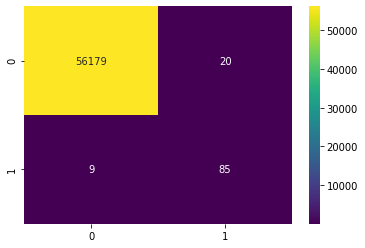

In [52]:
# confusion matrix
sns.heatmap(confusion_matrix(test_y,test_y_pred_resample),annot=True,fmt='d',cmap='viridis')
plt.show()

In [53]:
# precision score
precision = precision_score(test_y,test_y_pred_resample)
# recall score
recall = recall_score(test_y,test_y_pred_resample)
# f1 score
f1= f1_score(test_y,test_y_pred_resample)
print('Random Forest:\nPrecision Score=%.3f\nRecall Score=%.3f\nF1 Score=%.3f' % (precision,recall,f1))

Random Forest:
Precision Score=0.810
Recall Score=0.904
F1 Score=0.854


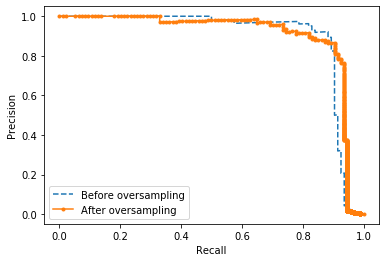

In [54]:
# Precision-Recall Curve
RF1_precision_resample,RF1_recall_resample,thresholds = precision_recall_curve(test_y,test_y_pred_proba_resample)

# plot
plt.plot(RF1_recall,RF1_precision,linestyle='--',label='Before oversampling')
plt.plot(RF1_recall_resample,RF1_precision_resample,marker='.',label='After oversampling')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [55]:
# auc
pr_auc = auc(RF1_recall_resample,RF1_precision_resample)
print('AUC=%.3f' % (pr_auc))

AUC=0.906


In [56]:
# Finetuning the decision threshold
from numpy import argmax
fscore = (2 * RF1_precision_resample * RF1_recall_resample) / (RF1_precision_resample + RF1_recall_resample)
# locate the index of the largest f1 score
ix = argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix],RF1_precision_resample[ix],RF1_recall_resample[ix]))

Best Threshold=0.596, F-Score=0.885, Precision=0.867, Recall=0.904


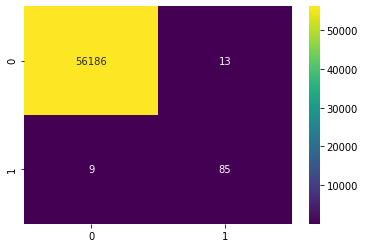

In [57]:
# new confusion matrix for threshold[ix]
test_y_pred_resample_new = [1 if proba >= thresholds[ix] else 0 for proba in test_y_pred_proba_resample]
sns.heatmap(confusion_matrix(test_y,test_y_pred_resample_new),annot=True,fmt='d',cmap='viridis')
plt.show()

In [58]:
### visualize estimators of random forest(single decision tree)
estimator = RF1.estimators_[0]  # select the first decision tree

In [59]:
feature_names = train_x.columns
tree = export_graphviz(estimator,out_file='tree.dot',
               feature_names=feature_names,
               class_names=['0','1'],
               rounded=True,proportion=False,
               precision=2,filled=True)

In [60]:
# Convert to png using system command( requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [61]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [69]:
## check feature importance 
feature_imp = pd.Series(RF1.feature_importances_,index=test_x.columns).sort_values(ascending=False)

V14       0.255895
V17       0.176630
V10       0.176241
V12       0.109458
V11       0.068015
V3        0.047546
V4        0.041983
V7        0.031247
V16       0.028402
V9        0.011690
Amount    0.011371
V18       0.011345
V2        0.009376
V1        0.005122
V6        0.004495
V5        0.003507
V19       0.003484
V27       0.002414
V24       0.001780
dtype: float64

In [70]:
%matplotlib inline

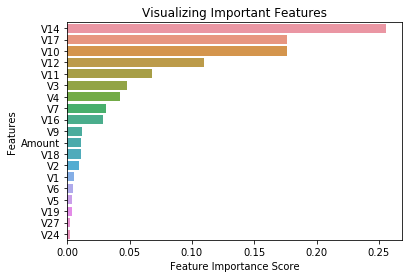

In [72]:
# create a bar plot
sns.barplot(x=feature_imp,y=feature_imp.index)
# add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()